# This file will prototype job processing for scheduling and utilization of hw



In [1]:
from pathlib import Path
import time
from datetime import datetime

import numexpr as ne
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import yaml

from urbandata import k_fold_urban_sound, UrbanSoundDataSet, train_one_epoch, validate
from visualize import plot_fold_results, plot_final_results

In [2]:
jobs_path = Path('./jobs')

def get_jobs(jobs_path):
    # Jobs starting with _ are ignored, like the default job
    return [f for f in jobs_path.iterdir() if f.is_file() and not f.name.startswith('_')]

jobs = get_jobs(jobs_path)

In [3]:
if len(jobs) == 1:
    print('There is {} job to process'.format(len(jobs)))
else:
    print('There are {} jobs to process'.format(len(jobs)))

There is 1 job to process


In [4]:
class CustomNN(torch.nn.Module):
    def __init__(self, name, sequential_arch):
        super().__init__()
        self.name = name
        self.model = torch.nn.Sequential(*sequential_arch)
    def forward(self, X):
        return self.model(X)

In [5]:
def evaluate_expression(value):
    try: 
        if isinstance(value, str) and any(op in value for op in ['+', '-', '*', '/']):
            return ne.evaluate(value).item()
        else:
            return value
    except Exception as e:
        raise ValueError('Failed to evaluate expression {}. {}'.format(value, e))

class TrainingJob():
    def __init__(self, job_path):
        self.path = job_path
        self.job = None
        self.start_time = 0.
        self.layers = []
        self.fold_accuracies = []
    
    def train(self):
        '''Training, assuming job is on urbansound dataset'''
        urban_metadata = self.data_path / 'metadata/UrbanSound8K.csv'
        urban_audio = self.data_path / 'audio'
        
        
        
        folds = k_fold_urban_sound(urban_metadata, self.dry_run)
        
        print(f'-----{len(folds)}-Fold Cross Validation-----')
        start_time = time.time()

        for fold_idx, fold_bundle in enumerate(tqdm(folds, desc='Fold progress')):
            print(f"Fold {fold_idx}:", end='')

            model = self.get_new_model()
            optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=self.momentum)

            train_ds = UrbanSoundDataSet(urban_audio,
                                         fold_bundle['train'],
                                         sample_rate=self.sample_rate,
                                         mel_kwargs=self.job['mel_kwargs'])
            validation_ds = UrbanSoundDataSet(urban_audio,
                                              fold_bundle['validation'],
                                              sample_rate=self.sample_rate,
                                              mel_kwargs=self.job['mel_kwargs'])
            print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")

            train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=self.is_shuffled)
            validation_dl = DataLoader(validation_ds, batch_size=self.batch_size, shuffle=self.is_shuffled)

            losses_for_fold, accs_for_fold = [], []
            for epoch in tqdm(range(self.epochs), desc='Epochs'):
                avg_loss, acc = train_one_epoch(train_dl, model, optimizer, self.loss_fn, self.device)
                avg_vloss, vacc = validate(validation_dl, model, self.loss_fn, self.device)

                losses_for_fold.append((avg_loss, avg_vloss))
                accs_for_fold.append((acc, vacc))
        #         print(f'LOSS train {avg_loss} val {avg_vloss}')
            print(f'Fold accuracy: {vacc*100:.2f}%')


            plot_fold_results(fold_idx, losses_for_fold, accs_for_fold)
            fold_accuracies.append(vacc)
        
        end_time = time.time()
        training_duration = end_time - start_time
        
        # TODO: move this to success processing?
        plot_final_results(self.fold_accuracies)
        self.kfold_valication_acc = np.mean(fold_accuracies)
        print(f"Training time: {training_duration:.2f} seconds")
    
    def get_new_model(self):
        return CustomNN(self.model_name, self.layers).to(self.device)
    
    def __enter__(self):
        self.start_time = time.time()
        
        with open(self.path, 'r') as f:
            self.job = yaml.load(f, yaml.FullLoader)
            
        self._validate_job()
        self.__inject()
        
        return self
            
    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        
        # todo: save job data: logs, pictures, model, etc... in completed dir.
        print('Job duration: {:.2f} seconds'.format(self.end_time-self.start_time))

#         if exc_type is not None:
#             self._failure_processing(exc_type)
#         else:
#             self._success_processing()
        
        return False
    
    def _validate_job(self):
        '''
        Perform minimal/basic job validation by checking YAML configuration for inconsistencies.
        '''
        assert 'model' in self.job
        assert 'name' in self.job['model']
        assert 'architecture' in self.job['model']
        
        assert 'ml_parameters' in self.job
        assert 'epochs' in self.job['ml_parameters']
        assert 'audio_parameters' in self.job
        assert 'job_parameters' in self.job
        
    def __inject(self):
        '''Injects dependencies. Assumes inputs are validated / healthy'''
        self.model_name = self.job['model']['name']
        
        for layer in self.job['model']['architecture']:
            cls = getattr(torch.nn, layer['layer_type'])
            layer_params = {key: evaluate_expression(value) for key, value in layer.items() if key != 'layer_type'}
            self.layers.append(cls(**layer_params))
        
        for key, value in self.job['ml_parameters'].items():
            setattr(self, key, value)
        for key, value in self.job['audio_parameters'].items():
            setattr(self, key, value)
        for key, value in self.job['job_parameters'].items():
            setattr(self, key, value)
        
        # Overrides for non-numeric / non-str types
        if getattr(self, 'loss_fn'):
            self.loss_fn = getattr(torch.nn, self.loss_fn)()
        if getattr(self, 'device'):
            self.device = torch.device(self.device)
        if getattr(self, 'data_path'):
            self.data_path = Path(self.data_path).expanduser()
        
    def _failure_processing(self, exc_type):
        dtime = datetime.now().strftime("%Y-%m-%d_%H-%M")
        exc = str(exc_type) if exc_type else "fail"
        dirname = f"{dtime}_{self.model_name}_E{self.epochs}_Exc{exc}"
        
        # mkdir dirname
        # move contents from './tmp/<hash>' to dirname
        
        raise notImplementedError
    def _success_processing(self):
        dtime = datetime.now().strftime("%Y-%m-%d_%H-%M")
        dirname = f"{dtime}_{self.model_name}_E{self.epochs}_Acc{kfold_valication_acc*100:.2f}"
        
        # mkdir dirname
        # move contents from './tmp/<hash>' to dirname
        
        raise notImplementedError

Processing: train1.yaml
CustomNN(
  (model): Sequential(
    (0): Conv2d(2, 60, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(60, 120, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=57600, out_features=256, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=256, out_features=10, bias=True)
    (14): Softmax(dim=1)
  )
)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 

Validation set size for fold 5 : 936
Validation set info: 

Total samples: 936
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 120        | 12.82%
engine_idling    | 107        | 11.43%
dog_bark         | 100        | 10.68%
children_playing | 100        | 10.68%
air_conditioner  | 100        | 10.68%
street_music     | 100        | 10.68%
drilling         | 100        | 10.68%
car_horn         | 98         | 10.47%
siren            | 71         | 7.59%
gun_shot         | 40         | 4.27%
----------------------------------------

Duration statistics: 
count    936.000000
mean       3.553224
std        1.032612
min        0.179305
25%        4.000000
50%        4.000000
75%        4.000000
max        4.000000
Name: duration, dtype: float64
-----------------------------------------------------------
Training set size for fold 6 : 7909
Training set info: 

Total samples: 7909
Class            | Frequency  | Percentage
--------------

Fold progress:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 0:	Size of train, val datasets: (392, 43)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 55.81%


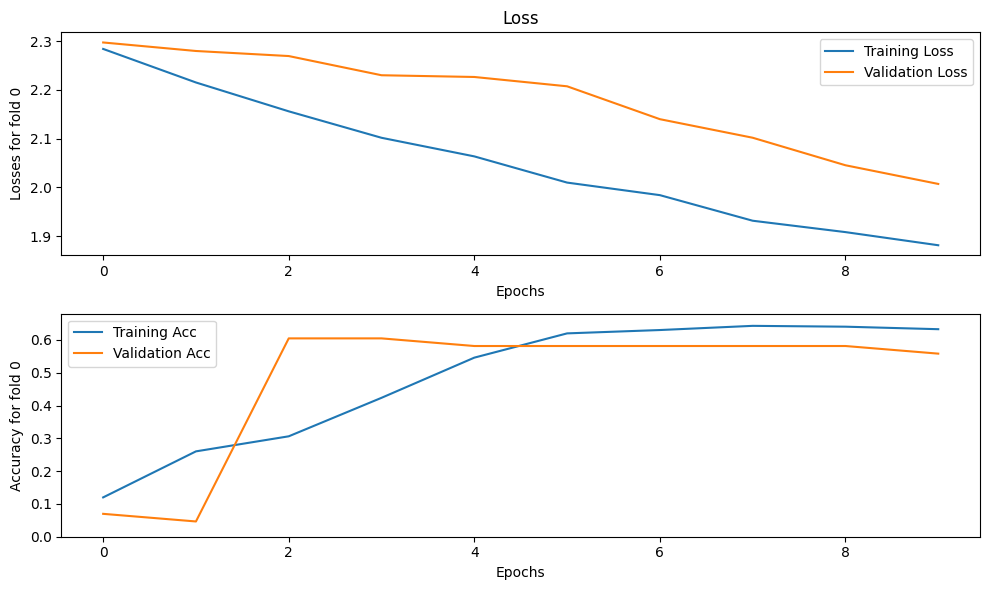

Fold 1:	Size of train, val datasets: (392, 44)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 13.64%


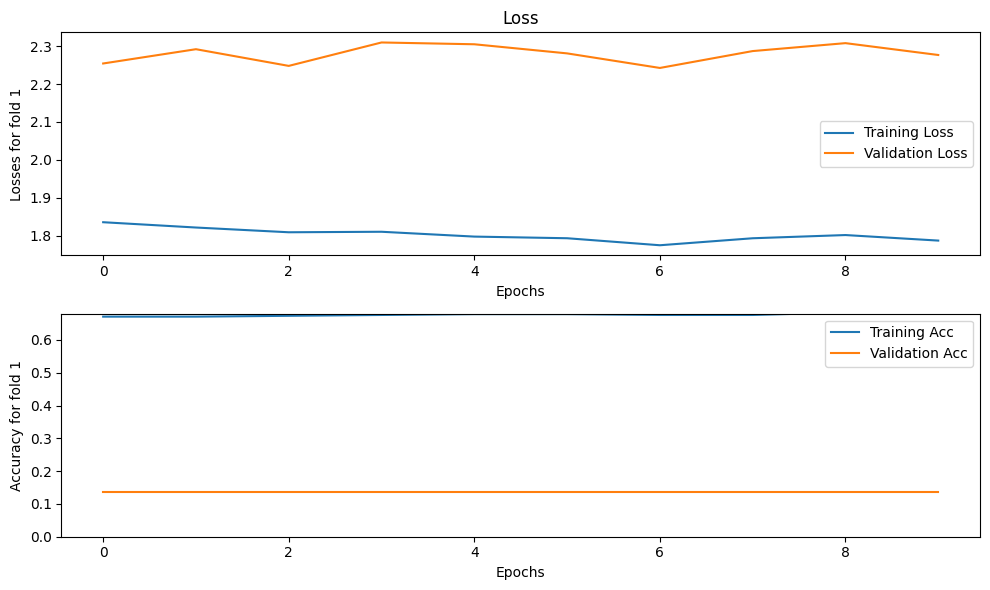

Fold 2:	Size of train, val datasets: (390, 46)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 71.74%


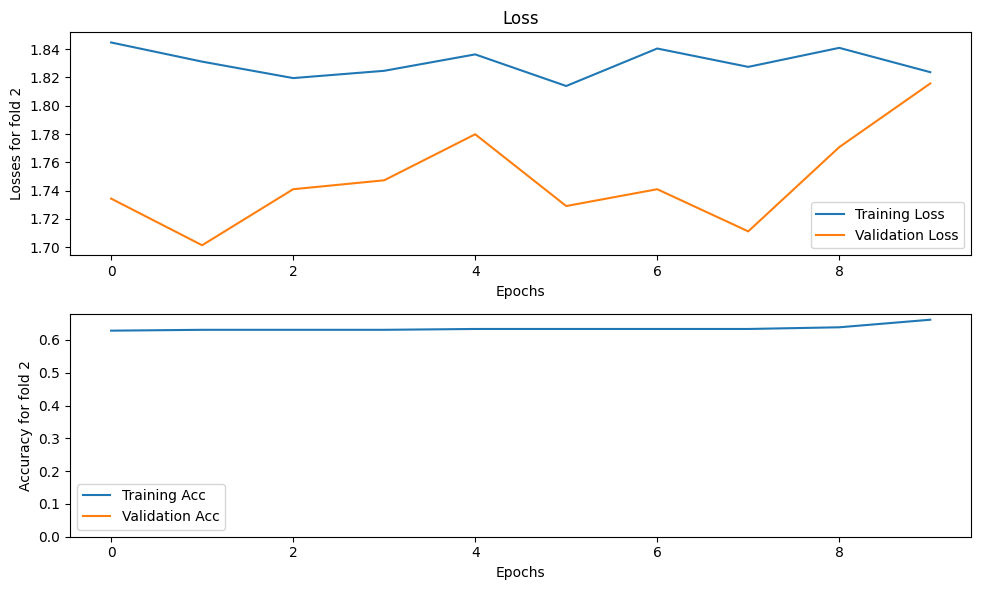

Fold 3:	Size of train, val datasets: (387, 49)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 20.41%


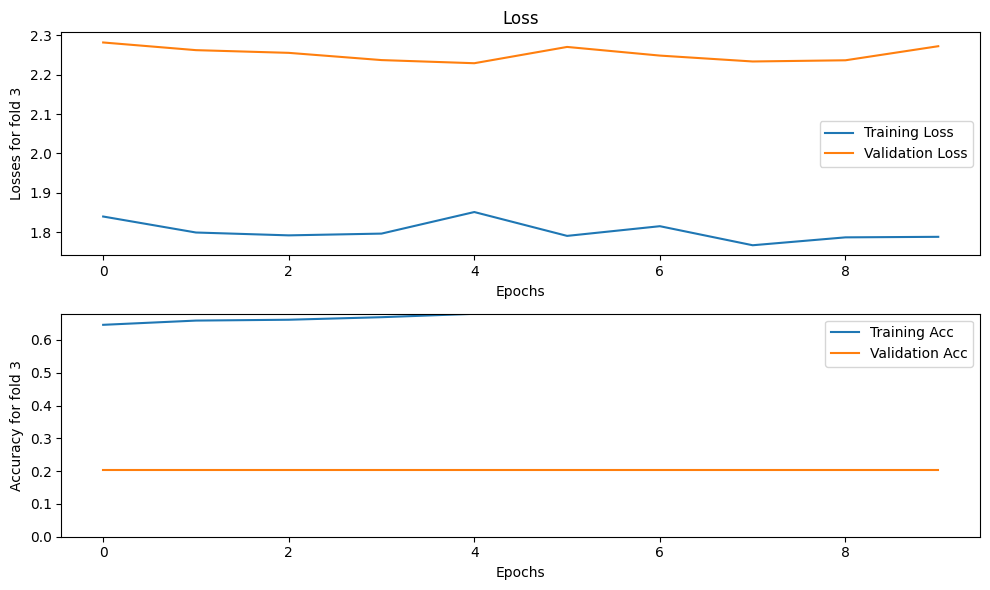

Fold 4:	Size of train, val datasets: (389, 46)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 34.78%


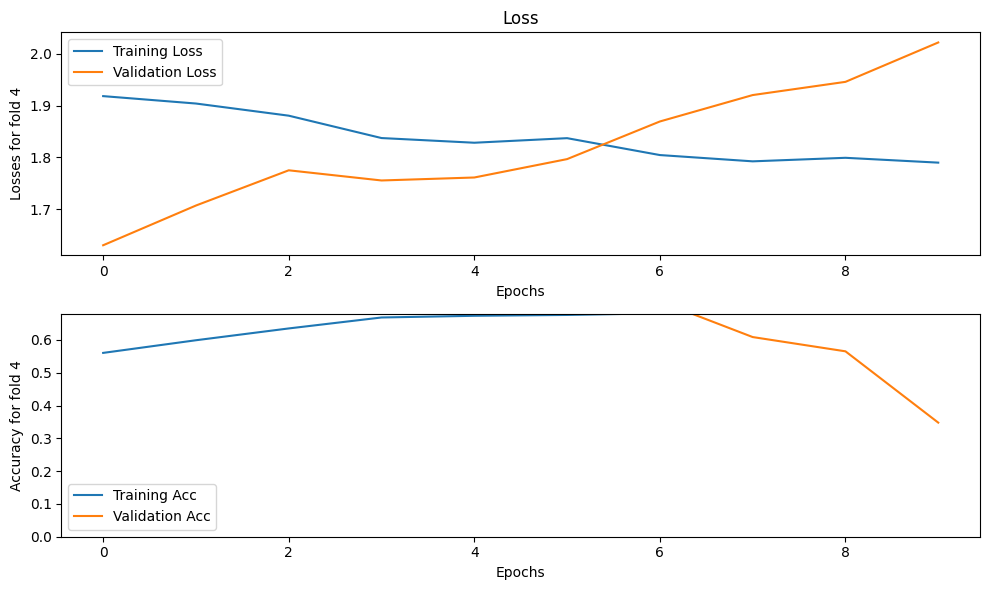

Fold 5:	Size of train, val datasets: (395, 41)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 41.46%


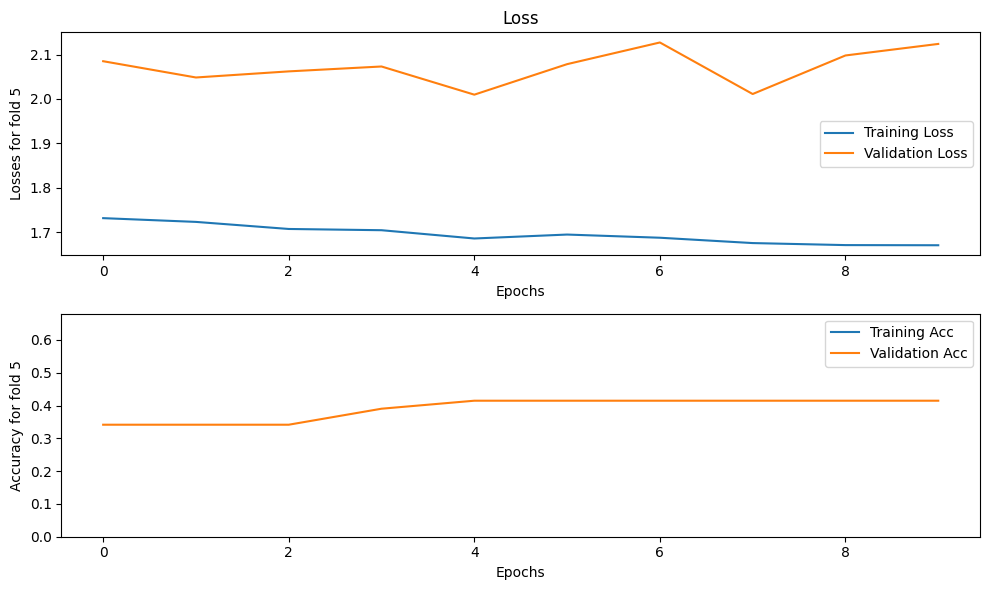

Fold 6:	Size of train, val datasets: (394, 41)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 65.85%


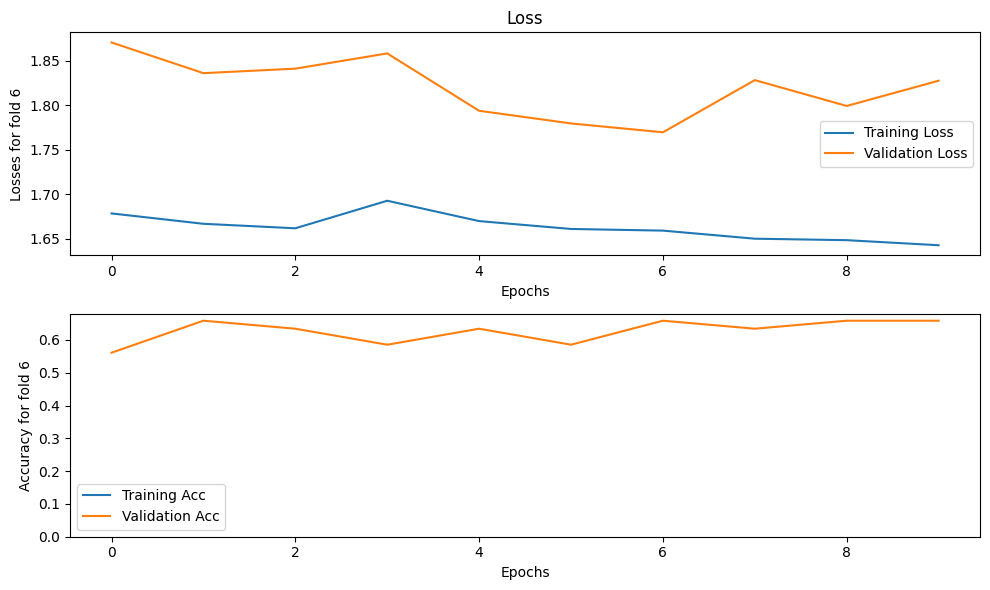

Fold 7:	Size of train, val datasets: (396, 40)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 77.50%


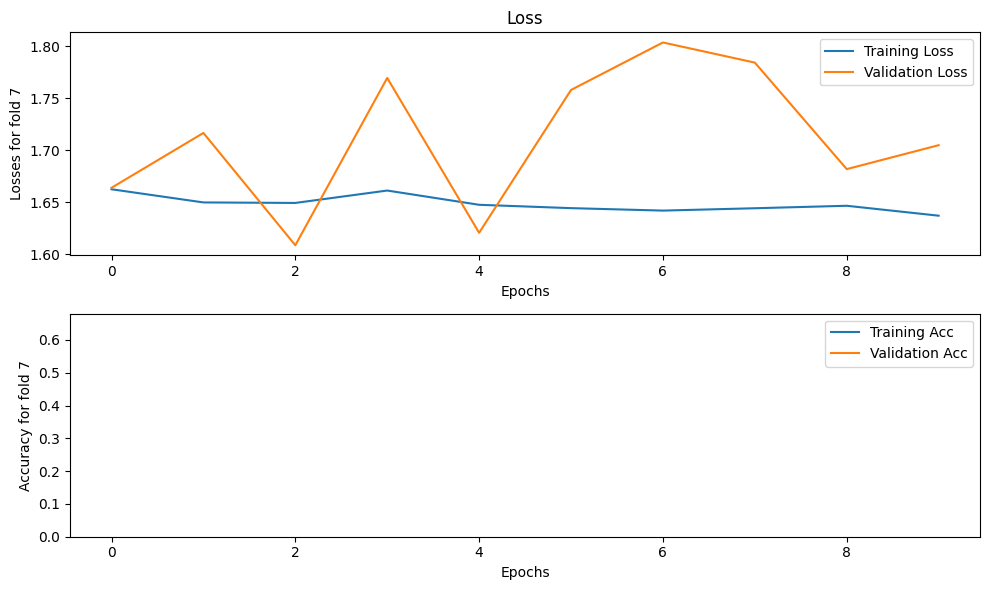

Fold 8:	Size of train, val datasets: (395, 40)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 67.50%


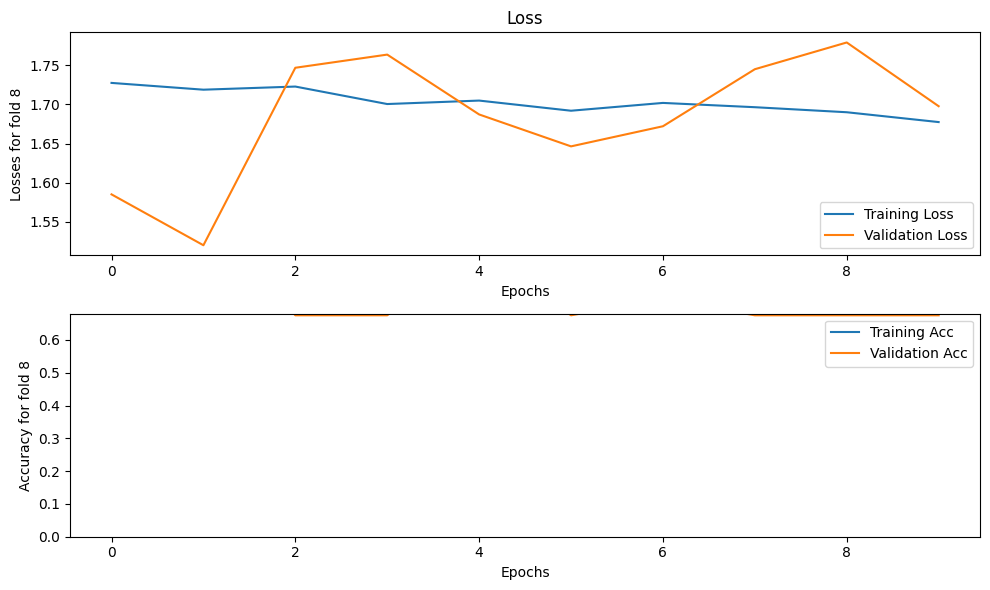

Fold 9:	Size of train, val datasets: (394, 41)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold accuracy: 75.61%


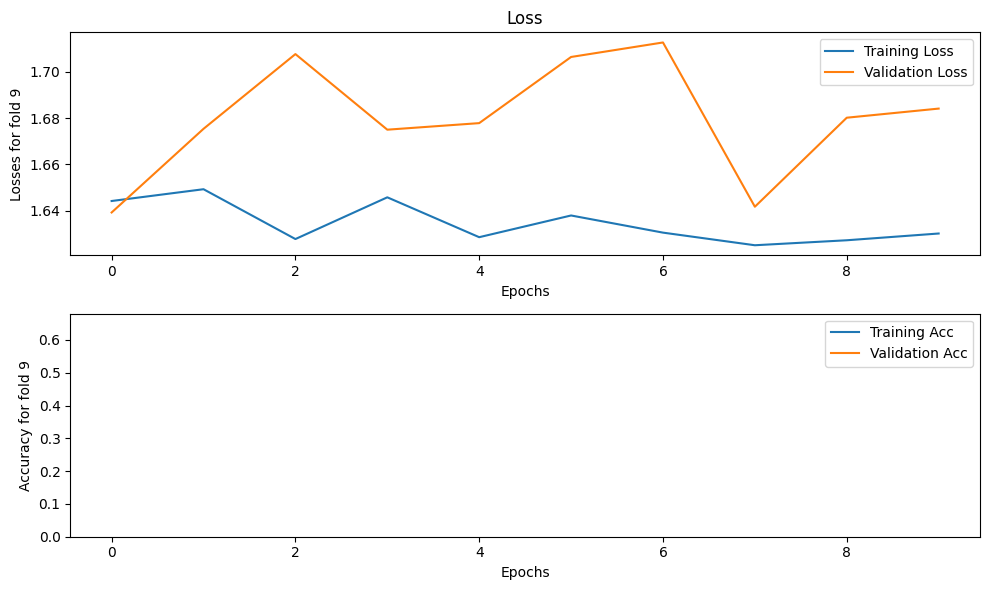

Training time: 207.93 seconds
Job duration: 209.29 seconds


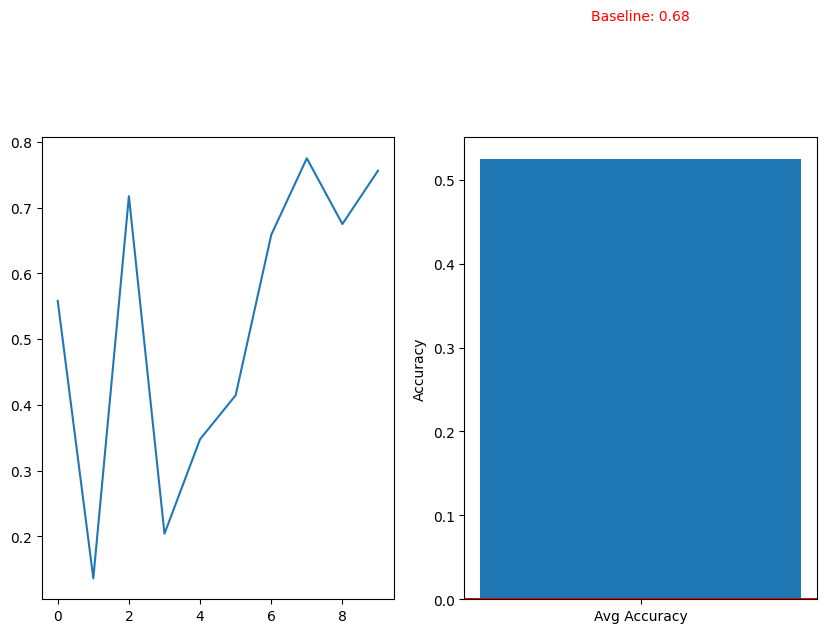

In [6]:
for job_path in jobs:
    with TrainingJob(job_path) as job:
        print('Processing: {}'.format(job.path.name))
        model = job.get_new_model()
        print(model)        
        job.train()


2024-10-24_18-16
2024-10-24_18-16_SimpleCNN_E100_Acc75.35
